# Описание работы

Датасет — test_atm_analysis.csv

В датасете инфомрация о операциях снятия и внесения денежных средств в банкоматах.
Описание полей:

•	TIME – дата время совершения операции;

•	TRANSACTION_ID – id операции;

•	AMOUNT – сумма операции;

•	CLIENT_ID -  id клиента;

•	BANK_ID – id банка, которому принадлежит банкомат;

•	CITY -  местоположение банкомата;

•	OPERATION_TYPE – тип операции;

•	FRAUD_FLAG – признак фрода, 1 — фрод, 0 — обычная операциях

Задания можно выполнять, используя python (Dataframe и другие библиотеки) или SQL (Clickhouse, Oracle, PostgreSQL).

1.	Напишите запрос, который показывает динамику оборотов и кол-ва операций по банкам в разрезе месяца. Какие можно сделать выводы из полученного результата?
2.	Напишите запрос, показывающий процентный рост операций в разрезе банка, от месяца к месяцу. Какой это был банк, какой тип операций и в каком месяце максимальный рост в % и в номинальных значениях оборота.
3.	Проведите анализ клиентов с FRAUD_FLAG = 1 и попробуйте понять, какие характеристики объединяют их.
Напишите запрос, позволяющий найти аналогичных клиентов, но с FRAUD_FLAG = 0.
Посчитайте долю операций таких клиентов от общей доли соответствующего типа операций в разрезе месяца.
4.	* - проведите всесторонний анализ датасета, представив статистику в разных срезах с графиками (библиотеки python) и выводами.

Если есть опыт использования ML\DL, попробуйте обучить модель на одном месяце и найте клиентов в других месяцах.
Будет плюсом, если вы оформите решение в ноутбуке на github.


# Импорты

In [ ]:
import pandas as pd
import requests as r
import datetime as dt
import seaborn as sns
from scipy.stats import describe
import numpy as np
import matplotlib.pyplot as plt
!pip install pandasql -q
import pandasql as psql

  Preparing metadata (setup.py) ... done


In [ ]:
from sklearn.utils import resample
import numpy as np
!pip install CatBoost -q
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [ ]:
direct_url = 'https://disk.yandex.ru/d/MM8oYj3D1PtBkg'
api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'
params = {'public_key': direct_url}
response = r.get(api_url, params=params)
if response.status_code == 200:
    link = response.json()['href']
    r.get(link)


In [ ]:
link = response.json()['href']

In [ ]:
with open('downloaded_file.7z', 'wb') as f:
    f.write(r.get(link).content)

In [ ]:
parol = '09102024'
!7z x /content/downloaded_file.7z -p{parol} -o/content/extracted_files


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 23109042 bytes (23 MiB)

Extracting archive: /content/downloaded_file.7z
--
Path = /content/downloaded_file.7z
Type = 7z
Physical Size = 23109042
Headers Size = 178
Method = LZMA2:24 7zAES
Solid = -
Blocks = 1

  0%      1%      5% - test_atm_analysis.csv                             10% - test_atm_analysis.csv                             14% - test_atm_analysis.csv                             19% - test_atm_analysis.csv                            

In [ ]:
data = pd.read_csv('/content/extracted_files/test_atm_analysis.csv')
data.head()

,TIME,TRANSACTION_ID,AMOUNT,CLIENT_ID,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG
0,2023-05-01 10:46:13,524834800723,390,BA2FE876DF8CDBDC5EC8549F764C996838D6EF9A3C0F5C...,1,Петропавловск-Камчатский г,Пополнение через наши банкоматы,0
1,2023-05-01 10:47:46,524834800746,310,BA2FE876DF8CDBDC5EC8549F764C996838D6EF9A3C0F5C...,1,Петропавловск-Камчатский г,Пополнение через наши банкоматы,0
2,2023-05-01 10:51:55,524834800795,390,17C0EC56C8190EC14D48749C760414BA8CFC565CD5E4E8...,1,Петропавловск-Камчатский г,Пополнение через наши банкоматы,0
3,2023-05-01 11:14:58,524840527908,80,00547AF159358A2956CD20E787F65D2B4EC82C70CF98F3...,1,Елизово г,Пополнение через наши банкоматы,0
4,2023-05-01 11:37:48,524848052828,590,2D0B6EBD900C5695C6A4380D29C71B173145BA7A5A56B3...,1,Елизово г,Пополнение через наши банкоматы,0


Данные загружены

## Методами pandas, python

# Предварительная обработка и анализ

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873843 entries, 0 to 873842
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   TIME            873843 non-null  object
 1   TRANSACTION_ID  873843 non-null  int64 
 2   AMOUNT          873843 non-null  int64 
 3   CLIENT_ID       873843 non-null  object
 4   BANK_ID         873843 non-null  int64 
 5   CITY            873642 non-null  object
 6   OPERATION_TYPE  873843 non-null  object
 7   FRAUD_FLAG      873843 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 53.3+ MB


В данных требуется приведение типа данных к требуему:
- time к типу datetime.

Необходимо выяснить природу пропусков в признаке city


In [ ]:
# привожу к формату datetime и извлекаю необходимые данные
data['TIME'] = pd.to_datetime(data['TIME'])
# выделим из даты год, месяц, день, время
data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']] = data['TIME'].apply(
    lambda x: pd.Series([x.year, x.month, x.day, x.hour, x.minute, x.second]))

In [ ]:
data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']]

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
0,2023,5,1,10,46,13
1,2023,5,1,10,47,46
2,2023,5,1,10,51,55
3,2023,5,1,11,14,58
4,2023,5,1,11,37,48
...,...,...,...,...,...,...
873838,2023,7,31,19,44,18
873839,2023,7,31,19,2,6
873840,2023,7,31,21,12,16
873841,2023,7,31,22,1,14


### Пропущенные значения в city

In [ ]:
data[data['CITY'].isna()]

,TIME,TRANSACTION_ID,AMOUNT,CLIENT_ID,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
5052,2023-05-01 18:37:08,525483926118,220,C2604C019FAABAEC32EDDEEDEEA7BB84D678CD6D5346C2...,34,NaN,Снятие через чужие банкоматы,0,2023,5,1,18,37,8
7350,2023-05-01 15:33:28,525515321938,130,B7FBD2F0C3339D1A40873BDCCE79337948C7CE12525330...,34,NaN,Снятие через чужие банкоматы,0,2023,5,1,15,33,28
29475,2023-05-03 11:11:08,525928764918,90,6DC22804E13BAC433D8A8998BD43D1207206FDD7B56C64...,34,NaN,Снятие через чужие банкоматы,0,2023,5,3,11,11,8
29779,2023-05-03 14:23:46,525931917536,200,12D2D08848AA46837FD1B58DDC5F370705C31F47F3659C...,34,NaN,Снятие через чужие банкоматы,0,2023,5,3,14,23,46
49064,2023-05-05 19:52:32,526281844732,310,A924A4281B6A5D2202935EA813A1391A13A4C5B688E93E...,34,NaN,Снятие через чужие банкоматы,0,2023,5,5,19,52,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856849,2023-07-29 12:38:37,546097874727,190,660B8AA20A757AED9CB58108202D22E95D05BF20C554CF...,34,NaN,Снятие через чужие банкоматы,0,2023,7,29,12,38,37
857903,2023-07-29 12:36:09,546104149039,550,660B8AA20A757AED9CB58108202D22E95D05BF20C554CF...,34,NaN,Снятие через чужие банкоматы,0,2023,7,29,12,36,9
858998,2023-07-29 12:16:42,546110560662,140,CF2FB113F56902D746236B00F9BB7BD5047EDE511A7AFF...,34,NaN,Снятие через чужие банкоматы,0,2023,7,29,12,16,42
867725,2023-07-30 09:18:45,546933925135,100,58386BE668E84C594D5B918D84A13CC07F17298E2645AF...,34,NaN,Снятие через чужие банкоматы,0,2023,7,30,9,18,45


In [ ]:
# проверю гипотезу что для всех пропущенных значений OPERATION_TYPE == Снятие через чужие банкоматы
data[data['CITY'].isna()]['OPERATION_TYPE'].unique()

array(['Снятие через чужие банкоматы'], dtype=object)

In [ ]:
# пробую сгруппировать по id бакомата
data[data['CITY'].notna()].groupby(['BANK_ID'])['CITY'].apply(lambda x: x.unique())

,CITY
BANK_ID,
1,"[Петропавловск-Камчатский г, Елизово г, Невель..."
2,"[UST DONETSKIY, YAROSLAVL, ROSTOV NA DON, KRYM..."
3,"[ELIZOVO G, KRASNOE NA VO, ZARINSK G, TIUMEN G..."
4,"[EKATERINBURG, BORISOGLEBSK, SARATOV, NOVOSIBI..."
5,"[CHELIABINSK, SAMARA, PERM, NOVOSIBIRSK, MOSCO..."
6,"[KOLTSOVO, BELOVO, NOVOKUZNETSK, POLYSAEVO, KE..."
7,"[LYUBERTSY, MARKS, MOSCOW, ST PETERSBURG, BERE..."
8,"[SURGUT, KALININSK, PERELYUB, BALAKOVO, KAVALE..."
9,"[MOSKVA, NIZHNIY NOVGO, KURGAN, KALACH NA DON,..."


Видим что такая группировка не дала особых результатов так как для каждого ID банкомата имеется список городов, и  много неявных дубликатов.

In [ ]:
# выведу полный списоск всех уникальных городов
#set(data['CITY'].values)

## я их скрыла чтобы не было простыни в коде

Эти неявные дубликаты неплохо было бы обработать, но их очень много, поэтому оставляю как есть

In [ ]:
#пробую найти город по Id client если снималась деньги в близкие даты то возможно заполнить тем же городом что и в предыдущей дате
# выделяю ID CLIENT у которых пропущено значение CITY
clients_no_city = data[data['CITY'].isna()]['CLIENT_ID'].values

In [ ]:
df_with_clients_no_city = data.loc[
    (data['CLIENT_ID'].isin(clients_no_city)) &
    (data['TIME'].dt.round('D').isin(data.loc[data['CITY'].isna(), 'TIME'].dt.round('D')))]

In [ ]:
# заполняю заглушкой чтобы не получить ошибку при группировках
mask = df_with_clients_no_city['CITY'].isna()
df_with_clients_no_city.loc[mask, 'CITY'] = df_with_clients_no_city.loc[mask, 'CITY'].fillna('no_info')

In [ ]:
# смотрю сколько есть городов not null для тех у кого есть пропуск
df_with_clients_no_city.shape

(405, 14)

In [ ]:
# сколько человек имеют пропуск
df_with_clients_no_city.groupby('CLIENT_ID').count()

,TIME,TRANSACTION_ID,AMOUNT,BANK_ID,CITY,OPERATION_TYPE,FRAUD_FLAG,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
CLIENT_ID,,,,,,,,,,,,,
0381E8DC2B71E8386DEF1C4517C22CE3240CE65F7B07905F00010B7E42E9E1A8,21,21,21,21,21,21,21,21,21,21,21,21,21
04048452EF26ABB5BE52238B1CC42FA632551379E7C59EA87109028B87DEBE13,1,1,1,1,1,1,1,1,1,1,1,1,1
05B8BBB086EA6F85396E533AD885E2580DB53C27EE489718819DB2D5D636DBC7,4,4,4,4,4,4,4,4,4,4,4,4,4
0BD5DB828491C29FC4D9DF43094BA8F5CE480ABD3DFC3FC70AA40F2C6BBC21A3,8,8,8,8,8,8,8,8,8,8,8,8,8
10914E840EEEF7D0BA6753D7F1476BCAE6666607F5F334D454ACFE79C4386D4D,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
F289ACD4A998999F41596657C152833A91F75B368E8C4C6B16A01ADB39AF28AC,12,12,12,12,12,12,12,12,12,12,12,12,12
F3182EE03797D66D65416A3E72ED518DB99E922FE357A9BF7F77C412F2D29215,7,7,7,7,7,7,7,7,7,7,7,7,7
F3FC716636450E0198326F184FEA3A1E2312E709CEC390255103BB5B9D32D278,6,6,6,6,6,6,6,6,6,6,6,6,6


Видим что в данных есть пользователи с большим числом операций, отберем с разницей в дате меньше 1 дня

In [ ]:
# Сначала сортируем данные по времени
df = df_with_clients_no_city.sort_values(by='TIME')
df_grouped = df.groupby(['CLIENT_ID'])[['CITY', 'TIME']].apply(lambda x: x.reset_index(drop = True))
df_grouped

CITY  \
CLIENT_ID                                                             
0381E8DC2B71E8386DEF1C4517C22CE3240CE65F7B07905... 0  SANKT PETERBU   
                                                   1  SANKT PETERBU   
                                                   2  SANKT PETERBU   
                                                   3  SANKT PETERBU   
                                                   4  SANKT PETERBU   
...                                                             ...   
FCACBF2398E331C07F3F9130B219F242D597D3288099283... 4    SHCHERBINKA   
                                                   5        no_info   
                                                   6        no_info   
                                                   7    SHCHERBINKA   
                                                   8        no_info   

                                                                    TIME  
CLIENT_ID                                                                 
0381E8DC2B71E8386DEF1C4517C22CE3240CE65F7B07905... 0 2023-05-03 16:16:48  
                                                   1 2023-05-11 11:39:24  
                                                   2 2023-05-11 15:17:49  
                                                   3 2023-05-15 13:41:53  
                                                   4 2023-05-18 11:00:48  
...                                                                  ...  
FCACBF2398E331C07F3F9130B219F242D597D3288099283... 4 2023-06-05 08:54:06  
                                                   5 2023-06-12 09:08:16  
                                                   6 2023-06-16 12:51:51  
                                                   7 2023-06-29 12:48:45  
                                                   8 2023-07-08 11:30:47  

[405 rows x 2 columns]

In [ ]:
# выведу все строки чтобы посмотреть
df_grouped[:50]

CITY  \
CLIENT_ID                                                              
0381E8DC2B71E8386DEF1C4517C22CE3240CE65F7B07905... 0   SANKT PETERBU   
                                                   1   SANKT PETERBU   
                                                   2   SANKT PETERBU   
                                                   3   SANKT PETERBU   
                                                   4   SANKT PETERBU   
                                                   5   SANKT PETERBU   
                                                   6   SANKT PETERBU   
                                                   7   SANKT PETERBU   
                                                   8   SANKT PETERBU   
                                                   9        Опочка г   
                                                   10        no_info   
                                                   11  SANKT PETERBU   
                                                   12       SEBEZH G   
                                                   13        no_info   
                                                   14  SANKT PETERBU   
                                                   15  SANKT PETERBU   
                                                   16  SANKT PETERBU   
                                                   17        no_info   
                                                   18  SANKT PETERBU   
                                                   19        OPOCHKA   
                                                   20  SANKT PETERBU   
04048452EF26ABB5BE52238B1CC42FA632551379E7C59EA... 0         no_info   
05B8BBB086EA6F85396E533AD885E2580DB53C27EE48971... 0         DMITROV   
                                                   1         DMITROV   
                                                   2         DMITROV   
                                                   3         no_info   
0BD5DB828491C29FC4D9DF43094BA8F5CE480ABD3DFC3FC... 0          MOSKVA   
                                                   1          MOSKVA   
                                                   2        Москва г   
                                                   3          MOSKVA   
                                                   4        Москва г   
                                                   5        Москва г   
                                                   6        Москва г   
                                                   7         no_info   
10914E840EEEF7D0BA6753D7F1476BCAE6666607F5F334D... 0          MOSKVA   
                                                   1          MOSKVA   
                                                   2          MOSCOW   
                                                   3          MOSCOW   
                                                   4         no_info   
12D2D08848AA46837FD1B58DDC5F370705C31F47F3659CD... 0         no_info   
                                                   1          MOSKVA   
                                                   2          MOSKVA   
                                                   3          MOSKVA   
                                                   4          MOSKVA   
                                                   5         no_info   
1A8E8FEEBA70B645A663257CCF6B3B04CCDABA8F2F7EEFF... 0         no_info   
                                                   1         no_info   
                                                   2       SCHELKOVO   
1CC9C02268B98661DE924577D1CF9E4C333645DCDF51DC1... 0         no_info   
                                                   1         no_info   

                                                                     TIME  
CLIENT_ID                                                                  
0381E8DC2B71E8386DEF1C4517C22CE3240CE65F7B07905... 0  2023-05-03 16:16:48  
                                                   1  2023-05-11 11:39:24  
               

Заполнить предыдущим или следующим я не могу, так как нужно дополнительно включить агрегацию по банкомату, а при такой агрегации сложно установить соседство. 200 строк не существенны для данного количества данных, поэтому оставляю везде заглушки.

In [ ]:
data.loc[data['CITY'].isna(), 'CITY'] = data.loc[data['CITY'].isna(), 'CITY'].fillna('no_info')
data.isna().sum()

,0
TIME,0
TRANSACTION_ID,0
AMOUNT,0
CLIENT_ID,0
BANK_ID,0
CITY,0
OPERATION_TYPE,0
FRAUD_FLAG,0
YEAR,0
MONTH,0


In [ ]:
data.to_csv('dataset_svk.csv', index = False)

In [ ]:
!pip install SQLAlchemy -q

# 1.Задание


Напишите запрос, который показывает динамику оборотов и кол-ва операций по банкам в разрезе месяца. Какие можно сделать выводы из полученного результата?

Для выполнения этой задачи мне необходимо сгруппировать данные по месяцу и банку. Затем посчитать количество операций и сумму транзакций

In [ ]:
# Группировка по месяцу и банку
result = data.groupby(['MONTH', 'BANK_ID']).agg(
    total_sum=('AMOUNT', 'sum'),
    operations_count=('TRANSACTION_ID', 'count'),
    median_transaction_sum = ('AMOUNT', 'median'),
    max_transaction = ('AMOUNT', 'max')
).reset_index()
result.sort_values(by = ['total_sum', 'operations_count'], ascending = False).head(10)

,MONTH,BANK_ID,total_sum,operations_count,median_transaction_sum,max_transaction
0,5,1,123245440,163436,390.0,154690
47,6,1,119906420,170483,390.0,156590
93,7,1,113390150,163204,380.0,156250
95,7,3,44771450,45866,390.0,23360
49,6,3,23682230,41712,310.0,22890
2,5,3,22473630,38938,310.0,20160
48,6,2,11856220,28705,230.0,15630
51,6,5,11552540,20914,310.0,7810
94,7,2,11414060,26809,230.0,15630
4,5,5,10972530,19768,340.0,7810


In [ ]:
# посмотрю что за банки снизу
result.sort_values(by = ['total_sum', 'operations_count'], ascending = False).tail(10)

,MONTH,BANK_ID,total_sum,operations_count,median_transaction_sum,max_transaction
136,7,45,5620,20,215.0,780
28,5,29,5590,58,90.0,160
78,6,33,5210,65,80.0,90
46,5,47,5180,25,160.0,470
88,6,43,5160,34,160.0,230
134,7,43,4670,33,160.0,230
42,5,43,4030,26,160.0,230
74,6,29,3490,34,90.0,470
32,5,33,3470,43,80.0,90
124,7,33,1690,21,80.0,90


Мы видим, что у нас есть банки у которых совокупное число транзакций значительно превышает остальные банки. Визуализирую динамику изменения числа транзакций по месяцам для банков, у кого

In [ ]:
data['MONTH'].unique()

array([5, 6, 7])

In [ ]:
# Считаем общую сумму транзакций за каждый месяц (5, 6, 7)
monthly_totals = result.groupby('MONTH')['total_sum'].sum()

# считаем долю каждого банка делю общий объем в месяце на объем банка
result['share'] = result.apply(
    lambda row: row['total_sum'] / monthly_totals[row['MONTH']],
    axis=1
)
# Пивотирую данные для построения графика
pivot_df = result.pivot(index='BANK_ID', columns='MONTH', values='share').fillna(0)

pivot_df.head()

MONTH,5,6,7
BANK_ID,,,
1,0.664100,0.646220,0.573399
2,0.057988,0.063898,0.057719
3,0.121098,0.127632,0.226403
4,0.023780,0.024258,0.019964
5,0.059125,0.062261,0.055011


In [ ]:
# проверю что вся сумма это 1
pivot_df.sum(axis=0)

,0
MONTH,
5,1.0
6,1.0
7,1.0


Выглядит очень странно что доля общих транзакций в общей сумме отсортирована по id банка


In [ ]:
# проверю гипотезу что данные искусственные и id банка действительно влияет на данные
result.sort_values(by = 'BANK_ID')

,MONTH,BANK_ID,total_sum,operations_count,median_transaction_sum,max_transaction,share
0,5,1,123245440,163436,390.0,154690,0.664100
47,6,1,119906420,170483,390.0,156590,0.646220
93,7,1,113390150,163204,380.0,156250,0.573399
1,5,2,10761540,26413,220.0,10050,0.057988
48,6,2,11856220,28705,230.0,15630,0.063898
...,...,...,...,...,...,...,...
91,6,46,21520,68,310.0,1250,0.000116
137,7,46,28740,79,310.0,3130,0.000145
92,6,47,14380,45,230.0,780,0.000077
46,5,47,5180,25,160.0,470,0.000028


In [ ]:
result.sort_values(by = 'total_sum', ascending=False).head(150)

,MONTH,BANK_ID,total_sum,operations_count,median_transaction_sum,max_transaction,share
0,5,1,123245440,163436,390.0,154690,0.664100
47,6,1,119906420,170483,390.0,156590,0.646220
93,7,1,113390150,163204,380.0,156250,0.573399
95,7,3,44771450,45866,390.0,23360,0.226403
49,6,3,23682230,41712,310.0,22890,0.127632
...,...,...,...,...,...,...,...
134,7,43,4670,33,160.0,230,0.000024
42,5,43,4030,26,160.0,230,0.000022
74,6,29,3490,34,90.0,470,0.000019
32,5,33,3470,43,80.0,90,0.000019


In [ ]:
result.sort_values(by = 'total_sum', ascending=False).tail(15)

,MONTH,BANK_ID,total_sum,operations_count,median_transaction_sum,max_transaction,share
120,7,29,7950,80,80.0,160,0.000040
82,6,37,7260,20,310.0,780,0.000039
34,5,35,6990,25,310.0,780,0.000038
38,5,39,6120,29,230.0,310,0.000033
36,5,37,5820,23,160.0,780,0.000031
136,7,45,5620,20,215.0,780,0.000028
28,5,29,5590,58,90.0,160,0.000030
78,6,33,5210,65,80.0,90,0.000028
46,5,47,5180,25,160.0,470,0.000028
88,6,43,5160,34,160.0,230,0.000028


Видимо это искусственные данные, либо id присваивались ранжированием, я буду использовать эту аномалию для удобства сортировки, так как теперь я знаю что сумма и количество транзакций примерно совпадают со своим порядковым номером

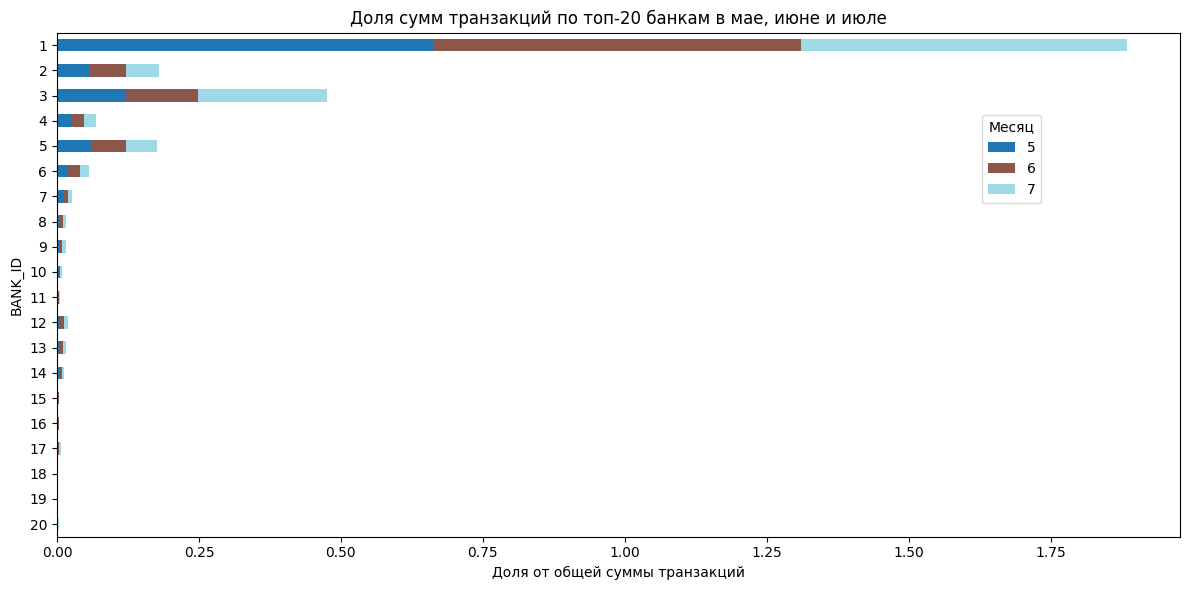

In [ ]:
# график сумм транзакций для топ 20
pivot_df[:20].sort_values(by = 'BANK_ID', ascending=False).plot(
    kind='barh',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20')

plt.title('Доля сумм транзакций по топ-20 банкам в мае, июне и июле')
plt.xlabel('Доля от общей суммы транзакций')
plt.ylabel('BANK_ID')
plt.legend(title='Месяц', bbox_to_anchor=(.85, 0.75), loc='center')
plt.tight_layout()
plt.show()

Доля получается более 1 так как я разместила на одном графике и доля суммируется

На графике и видно что  лидирующие позиции каждый месяц занимают одни и те же банки, в особенности банк 1, значительная часть от общих транзакций приходится на него.

Банки  2, 3 и 5 также неизменно занимают  значимую роль в общей картине транзакций.
Все банки стабильно сохраняют свои позиции в каждом из месяцев, что указывает на постоянную активность и присутствие на рынке.


Остальные банки, такие как имеют сщественно меньшие доли и их вклад в общую сумму каждый месяц составляет менее 5%.


Доля  доля самого крупного банка (1) заметно превосходит доли других банков


Мы увидели высокую концентрацию транзакций в единственном доминирующем банке 1. Структура транзакций остается неизменной от месяца к месяцу.

Но посмотрим распределение по квантилям так как медианы выглядят схожими, и вероятно такое большое влияние оказывают максимальные транзакции

In [ ]:
# выведу топ 5 банков с наибольшей суммой транзакций
top_5_banks = result.groupby('BANK_ID')['total_sum'].sum().nlargest(5).index

#  5 банков с наименьшей суммой транзакций
bottom_5_banks = result.groupby('BANK_ID')['total_sum'].sum().nsmallest(5).index

# фильтрую данные  для топ 5 и боттом 5 банков
top_5_data = data[data['BANK_ID'].isin(top_5_banks)]
bottom_5_data = data[data['BANK_ID'].isin(bottom_5_banks)]

# describe для получения статистики по суммам транзакций для каждого месяца
top_5_describe = top_5_data.groupby(['MONTH', 'BANK_ID'])['AMOUNT'].describe()
bottom_5_describe = bottom_5_data.groupby(['MONTH', 'BANK_ID'])['AMOUNT'].describe()

In [ ]:
top_5_describe

count        mean          std   min    25%    50%    75%  \
MONTH BANK_ID                                                                 
5     1        163436.0  754.089919  1438.131391  80.0  170.0  390.0  630.0   
      2         26413.0  407.433461   696.841941  80.0  120.0  220.0  470.0   
      3         38938.0  577.164467   952.397087  10.0  160.0  310.0  550.0   
      4         13745.0  321.070935   541.009197  50.0  120.0  160.0  380.0   
      5         19768.0  555.065257   792.818385  10.0  160.0  340.0  550.0   
6     1        170483.0  703.333588  1554.419995   0.0  160.0  390.0  630.0   
      2         28705.0  413.036753   705.933085  80.0  120.0  230.0  470.0   
      3         41712.0  567.755802   994.281632   0.0  160.0  310.0  510.0   
      4         13743.0  327.523103   557.964240  10.0  120.0  160.0  390.0   
      5         20914.0  552.383093   788.514945  70.0  160.0  310.0  550.0   
7     1        163204.0  694.775557  1507.204899  80.0  160.0  380.0  630.0   
      2         26809.0  425.754784   716.516927  80.0  120.0  230.0  470.0   
      3         45866.0  976.135918  1685.817156   0.0  160.0  390.0  780.0   
      4         12445.0  317.226999   480.698357  80.0  120.0  160.0  390.0   
      5         19826.0  548.692626   790.196563  20.0  160.0  330.0  550.0   

                    max  
MONTH BANK_ID            
5     1        154690.0  
      2         10050.0  
      3         20160.0  
      4         10000.0  
      5          7810.0  
6     1        156590.0  
      2         15630.0  
      3         22890.0  
      4          9380.0  
      5          7810.0  
7     1        156250.0  
      2         15630.0  
      3         23360.0  
      4         10060.0  
      5          7810.0

In [ ]:
bottom_5_describe

count        mean         std   min    25%    50%    75%    max
MONTH BANK_ID                                                                 
5     29        58.0   96.379310   26.069965  80.0   80.0   90.0   90.0  160.0
      33        43.0   80.697674    2.577696  80.0   80.0   80.0   80.0   90.0
      37        23.0  253.043478  225.800290  80.0  100.0  160.0  310.0  780.0
      43        26.0  155.000000   36.578682  80.0  142.5  160.0  160.0  230.0
      47        25.0  207.200000  121.570281  80.0  130.0  160.0  230.0  470.0
6     29        34.0  102.647059   65.750162  80.0   90.0   90.0   90.0  470.0
      33        65.0   80.153846    1.240347  80.0   80.0   80.0   80.0   90.0
      37        20.0  363.000000  246.365155  80.0  160.0  310.0  470.0  780.0
      43        34.0  151.764706   47.063502  80.0  132.5  160.0  167.5  230.0
      47        45.0  319.555556  232.574089  80.0  120.0  230.0  470.0  780.0
7     29        80.0   99.375000   31.955022  80.0   80.0   80.0   90.0  160.0
      33        21.0   80.476190    2.182179  80.0   80.0   80.0   80.0   90.0
      37        30.0  268.666667  141.585440  80.0  115.0  295.0  390.0  470.0
      43        33.0  141.515152   40.087499  80.0  110.0  160.0  160.0  230.0
      47        31.0  286.774194  221.500746  80.0  140.0  160.0  470.0  780.0

In [ ]:
# визуализирую mean, std, max
bottom_5_describe.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [ ]:
statistics_accecing = pd.concat([bottom_5_describe[['50%', 'max', 'std']],top_5_describe[['50%', 'max', 'std']]], axis = 0)

In [ ]:
statistics_accecing

50%       max          std
MONTH BANK_ID                              
5     29        90.0     160.0    26.069965
      33        80.0      90.0     2.577696
      37       160.0     780.0   225.800290
      43       160.0     230.0    36.578682
      47       160.0     470.0   121.570281
6     29        90.0     470.0    65.750162
      33        80.0      90.0     1.240347
      37       310.0     780.0   246.365155
      43       160.0     230.0    47.063502
      47       230.0     780.0   232.574089
7     29        80.0     160.0    31.955022
      33        80.0      90.0     2.182179
      37       295.0     470.0   141.585440
      43       160.0     230.0    40.087499
      47       160.0     780.0   221.500746
5     1        390.0  154690.0  1438.131391
      2        220.0   10050.0   696.841941
      3        310.0   20160.0   952.397087
      4        160.0   10000.0   541.009197
      5        340.0    7810.0   792.818385
6     1        390.0  156590.0  1554.419995
      2        230.0   15630.0   705.933085
      3        310.0   22890.0   994.281632
      4        160.0    9380.0   557.964240
      5        310.0    7810.0   788.514945
7     1        380.0  156250.0  1507.204899
      2        230.0   15630.0   716.516927
      3        390.0   23360.0  1685.817156
      4        160.0   10060.0   480.698357
      5        330.0    7810.0   790.196563

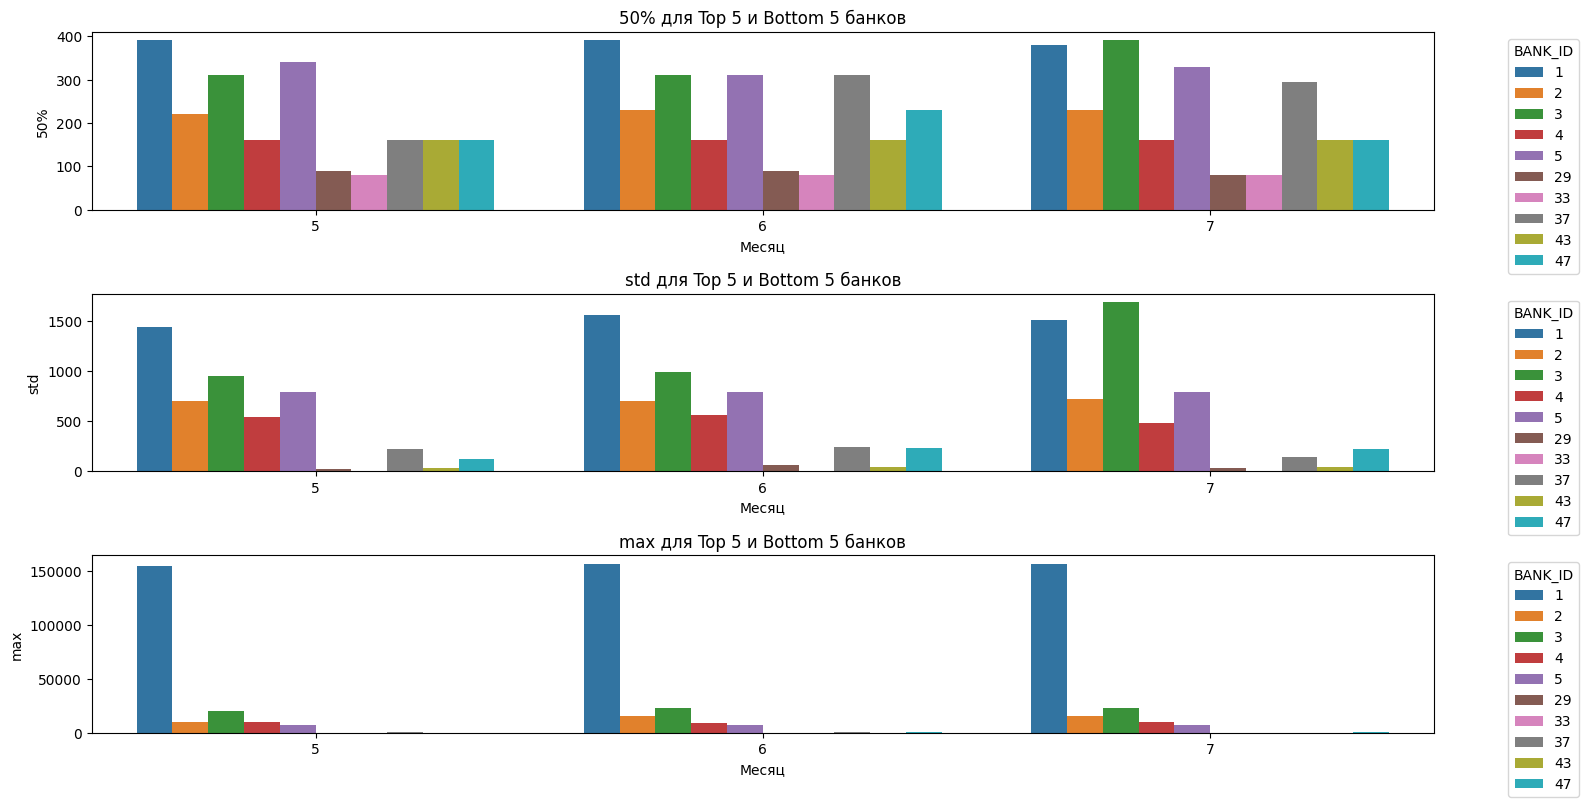

In [ ]:
# Параметры для визуализации и анализа
parameters = ['50%', 'std', 'max']

#  bar plot для каждого параметра
plt.figure(figsize=(16, 8))

for i, param in enumerate(parameters):
    plt.subplot(3, 1, i + 1)
    sns.barplot(
        data = statistics_accecing,
        x='MONTH', y=param, hue = 'BANK_ID',
        palette='tab10'
    )
    plt.title(f'{param} для Top 5 и Bottom 5 банков')
    plt.xlabel('Месяц')
    plt.ylabel(param)
    plt.legend(title = 'BANK_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plt.show()

Из графиков выше очевидно, что такую разницу в долю объема операций для этих банков вносят операции с большой суммой, так как медианные значения суммы операций для 5 верхних и 5 нижних находятся на сопостовимом уровне, в то время как стандартное отклонение и максимальные операции сильно разнятся для этих банков. Получается что для топ банков имеем сильно скошенное распределение

Оцени вид распределений для топ и боттом банков

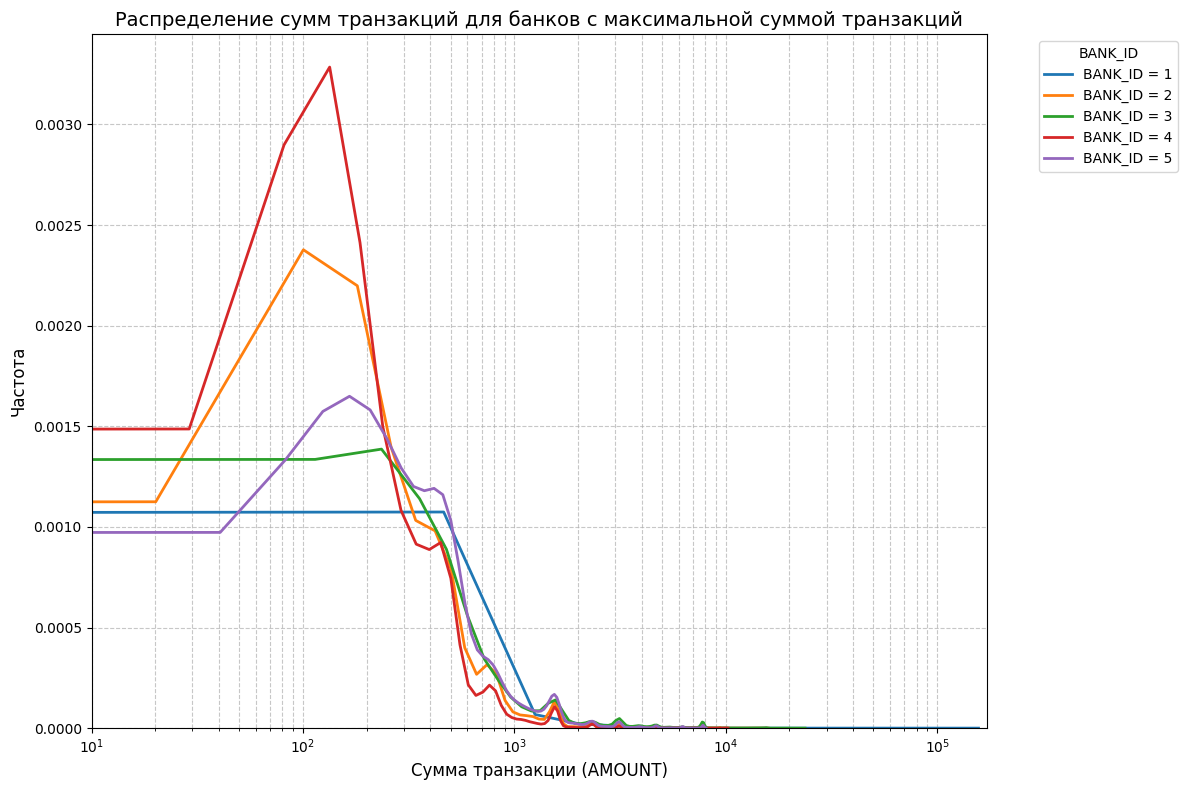

In [ ]:
# данные для банков с ID = 1, 2, 3, 4, 5
banks_ids = [1, 2, 3, 4, 5]
filtered_data = data[data['BANK_ID'].isin(banks_ids)]

#  график распределения сумм транзакций (AMOUNT) для банков с ID = 1, 2, 3, 4, 5
plt.figure(figsize=(12, 8))

# kdeplot для распределения
for bank_id in banks_ids:
    sns.kdeplot(
        data=filtered_data[filtered_data['BANK_ID'] == bank_id],
        x='AMOUNT',
        label=f'BANK_ID = {bank_id}',
        linewidth=2
    )
plt.title('Распределение сумм транзакций для банков с максимальной суммой транзакций', fontsize=14)
plt.xlabel('Сумма транзакции (AMOUNT)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.xscale('log')  # для визуализации больших разбросов
plt.grid(visible=True, which='both', linestyle='--', alpha=0.7)
plt.xlim(10, filtered_data['AMOUNT'].max() * 1.1)  #  границы оси X
plt.legend(title='BANK_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


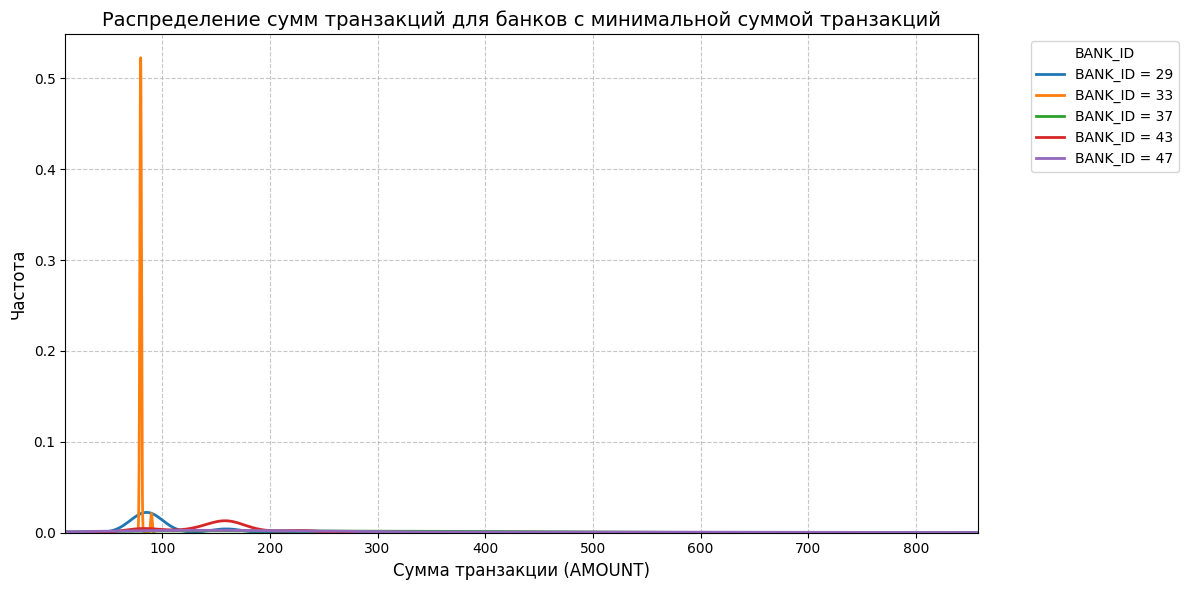

In [ ]:
# строю такое же распределие для хвостовых банков

banks_ids = bottom_5_describe.index.get_level_values(1).unique().values
filtered_data = data[data['BANK_ID'].isin(banks_ids)]

#  график распределения сумм транзакций (AMOUNT) для банков с ID = 1, 2, 3, 4, 5
plt.figure(figsize=(12, 6))

# kdeplot для распределения
for bank_id in banks_ids:
    sns.kdeplot(
        data=filtered_data[filtered_data['BANK_ID'] == bank_id],
        x='AMOUNT',
        label=f'BANK_ID = {bank_id}',
        linewidth=2
    )
plt.title('Распределение сумм транзакций для банков с минимальной суммой транзакций', fontsize=14)
plt.xlabel('Сумма транзакции (AMOUNT)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', alpha=0.7)
plt.xlim(10, filtered_data['AMOUNT'].max() * 1.1)  #  границы оси X
plt.legend(title='BANK_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

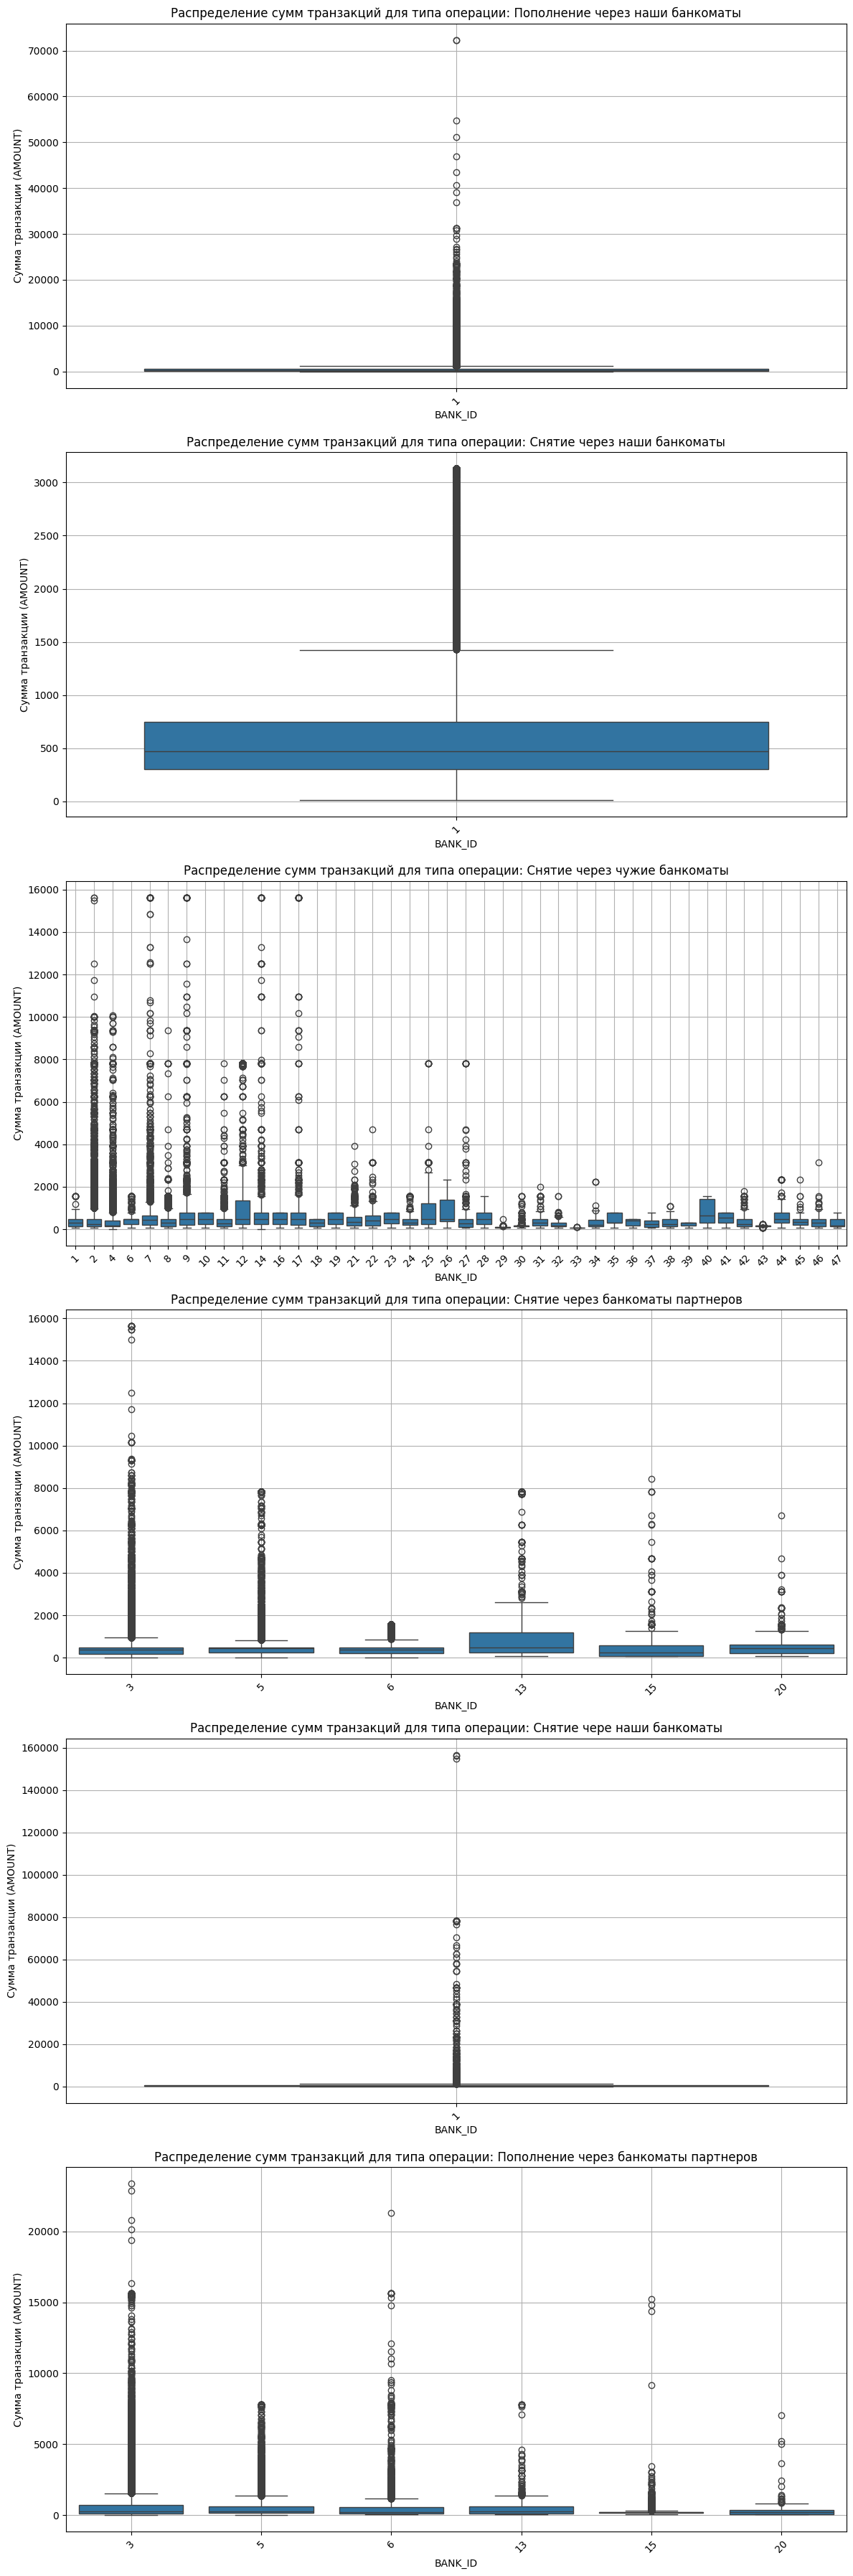

In [ ]:
# выведу информацию о том как распределяются по банкам основные категории операций
unique_operation_types = data['OPERATION_TYPE'].unique()

plt.figure(figsize=(12, 6 * len(unique_operation_types)))

# для всех тип операции отдельный график
for i, op_type in enumerate(unique_operation_types, 1):
    plt.subplot(len(unique_operation_types), 1, i)
    sns.boxplot(x='BANK_ID', y='AMOUNT', data=data[data['OPERATION_TYPE'] == op_type])
    plt.title(f'Распределение сумм транзакций для типа операции: {op_type}')
    plt.xlabel('BANK_ID')
    plt.ylabel('Сумма транзакции (AMOUNT)')
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

C этих графиков видно что банк 1 это свой банк, этим может объясняться его основная доля в количестве общих транзакций, а остальные банки из top 5 это партнеры.

Из анализа распределений сумм транзакций для 2-х групп банков: с максимальным оборотом и минимальным, мы видим, что они критично различаются по следующим параметрам:
- для 1-й группы характерно что основная доля операция сосредоточена в диапазоне больших сумм, и хвосты уходят плавно в зону редких значений
- для 2-й группы характерно то что основная доля операций выпадает на очень мелкие значения сумм, и хвосты для этой группы то, что для первой группы находится в основной части распределения. Причем тут есть пики для одного банка по частоте транзакций на незначительную сумму.

Из этих графиков можно сделать предположения:
- банки с наименьшим значением суммы транзакций используются для каких-то фиксированных сумм, в то время как первая группа обладает большим диапазоном и возможно обслуживает иную категорию лиц, возможно юр лица.


# 2.Задание на sql

Эту часть задания я выполню с помощью sql

Напишите запрос, показывающий процентный рост операций в разрезе банка, от месяца к месяцу. Какой это был банк, какой тип операций и в каком месяце максимальный рост в % и в номинальных значениях оборота.

Сначала создаю временную таблицу, которая группирует данные по месяцу, идентификатору банка  и типу операции .
 Для них считаю общую сумму транзакций  за каждый месяц чтобы посмотреть сколько всего денег было обработано каждым банком для каждого типа операции в каждый месяц.

ПОтом я соединяю данные текущего месяца с данными предыдущего месяца чтобы сравнивать суммы транзакций между текущим и предыдущим месяцами.
  И рассчитываю:
- процентный рост суммы транзакций в процентах
- номинальный рост(абсолютное значение разныцы суммы транзакций)

И из запроса я увижу какие банки и какие операции имеют max рост

In [ ]:
# запрос SQL
query = """
WITH monthly_sum AS (
    SELECT
        MONTH,
        BANK_ID,
        OPERATION_TYPE,
        SUM(AMOUNT) AS total_sum
    FROM df
    GROUP BY
        MONTH, BANK_ID, OPERATION_TYPE
),
monthly_growth AS (
    SELECT
        mt1.BANK_ID,
        mt1.OPERATION_TYPE,
        mt1.MONTH AS current_month,
        mt1.total_sum AS current_sum,
        mt2.total_sum AS previous_sum,
        ((mt1.total_sum - mt2.total_sum) / mt2.total_sum) * 100 AS percentage_growth,
        (mt1.total_sum - mt2.total_sum) AS nominal_growth
    FROM
        monthly_sum mt1
    LEFT JOIN
        monthly_sum mt2 ON mt1.BANK_ID = mt2.BANK_ID
        AND mt1.OPERATION_TYPE = mt2.OPERATION_TYPE
        AND mt1.MONTH = mt2.MONTH + 1
    WHERE
        mt2.total_sum IS NOT NULL
)
SELECT
    BANK_ID,
    OPERATION_TYPE,
    current_month,
    percentage_growth,
    nominal_growth
FROM
    monthly_growth
ORDER BY
    percentage_growth DESC
LIMIT 10;
"""

In [ ]:
# вывожу в df
result = psql.sqldf(query, locals())
result

,BANK_ID,OPERATION_TYPE,current_month,percentage_growth,nominal_growth
0,1,Пополнение через наши банкоматы,6,100,7000
1,9,Снятие через чужие банкоматы,6,100,810
2,5,Пополнение через банкоматы партнеров,7,100,1510
3,7,Снятие через чужие банкоматы,7,100,1810
4,1,Снятие чере наши банкоматы,6,0,-17190
5,1,Снятие через наши банкоматы,6,0,-2980
6,2,Снятие через чужие банкоматы,6,0,-1610
7,3,Пополнение через банкоматы партнеров,6,0,4160
8,3,Снятие через банкоматы партнеров,6,0,-2580
9,4,Снятие через чужие банкоматы,6,0,2070


На основе  данных по росту операций в разрезе банков можно сделать следующие выводы:

- Банк  1 показал 100% рост в июне по операции 'Пополнение через наши банкоматы' с номинальным увеличением оборота на 7000.
Банк  9 также показал 100% рост в июне по операции 'Снятие через чужие банкоматы' с номинальным ростом на 810.
- В июле у банка 5 был также 100% рост по суммам транзакций  для операции 'Пополнение через банкоматы партнеров как и у банка  7 для операции 'Снятие через чужие банкоматы'.

100% рост может говорит о том, что в предыдущем месяце сумма операций по этим направлениям была нулевой, а в текущем месяце был резкий рост по цифрам, хотя эти цифры сложно оценить насколько они значимы из за особенностей датасета.

Несколько банков показали нулевой процентный рост (0%) что может говоирть о снижении активности по этим операциям.

- В целом, несмотря на наличие случаев с 100% ростом, в абсолютных значениях приросты незначительны, что, возможно не сильно влияет на общую картину.


# 3.Задание на SQL

Проведите анализ клиентов с FRAUD_FLAG = 1 и попробуйте понять, какие характеристики объединяют их. Напишите запрос, позволяющий найти аналогичных клиентов, но с FRAUD_FLAG = 0. Посчитайте долю операций таких клиентов от общей доли соответствующего типа операций в разрезе месяца.

Для того чтобы найти признаки фрода вручную я сделаю следующее:
-  найду среднюю сумму транзакций для фрода
- сгруппирую данные по  OPERATION_TYPE, CITY и BANK_ID.
для этой группировки
   
Это поможет мне выявить типы операций и в каких городах чаще всего имеют определенные средние суммы фродовых транзакций для каждого банка.

In [ ]:
query = """
SELECT
    OPERATION_TYPE,
    CITY,
    BANK_ID,
    AVG(AMOUNT) AS avg_fraud_amount
FROM
    data
WHERE
    FRAUD_FLAG = 1
GROUP BY
    OPERATION_TYPE, CITY, BANK_ID;
"""

#  sql запрос
fraud_characteristics = psql.sqldf(query, locals())
fraud_characteristics

,OPERATION_TYPE,CITY,BANK_ID,avg_fraud_amount
0,Пополнение через банкоматы партнеров,ASTRAKHAN G,3,281.428571
1,Пополнение через банкоматы партнеров,BATAYSK,5,1140.000000
2,Пополнение через банкоматы партнеров,BELOVO,6,1303.333333
3,Пополнение через банкоматы партнеров,BERDSK,5,1880.000000
4,Пополнение через банкоматы партнеров,CHITA,5,1180.000000
...,...,...,...,...
109,Снятие через банкоматы партнеров,UFA,5,454.000000
110,Снятие через банкоматы партнеров,UKHTA G,3,226.000000
111,Снятие через банкоматы партнеров,VERHNERUSSKOE,6,1130.000000
112,Снятие через банкоматы партнеров,VOLGOGRAD,5,430.000000


Теперь я проанализирую стандартное отклонение значений среднего чтобы оценить, разброс суммы фродовых транзакций в каждой группе (банк, город и тип операции).

In [ ]:
# считаем стандартное отклонение с использованием pandas
stddev_values = (
    data[data['FRAUD_FLAG'] == 1]
    .groupby(['OPERATION_TYPE', 'CITY', 'BANK_ID'])['AMOUNT']
    .std()
    .reset_index(name='stddev_fraud_amount')
)
print(f'В таблице stddev_value {stddev_values.isna().sum()} пропусков')
stddev_values

В таблице stddev_value OPERATION_TYPE          0
CITY                    0
BANK_ID                 0
stddev_fraud_amount    26
dtype: int64 пропусков


,OPERATION_TYPE,CITY,BANK_ID,stddev_fraud_amount
0,Пополнение через банкоматы партнеров,ASTRAKHAN G,3,127.857808
1,Пополнение через банкоматы партнеров,BATAYSK,5,282.842712
2,Пополнение через банкоматы партнеров,BELOVO,6,1117.333134
3,Пополнение через банкоматы партнеров,BERDSK,5,NaN
4,Пополнение через банкоматы партнеров,CHITA,5,226.274170
...,...,...,...,...
109,Снятие через банкоматы партнеров,UFA,5,35.777088
110,Снятие через банкоматы партнеров,UKHTA G,3,83.426614
111,Снятие через банкоматы партнеров,VERHNERUSSKOE,6,608.111832
112,Снятие через банкоматы партнеров,VOLGOGRAD,5,80.000000


In [ ]:
# заполняю 0 так как это вероятнее всего из за того что было меньше 2 значений после группировки
stddev_values.fillna(0, inplace = True)

In [ ]:
# Объединяем результаты с помощью merge
fraud_characteristics = fraud_characteristics.merge(
    stddev_values,
    on=['OPERATION_TYPE', 'CITY', 'BANK_ID'],
    how='left',
    suffixes=('', '_drop')
)
print(f'В объединенной таблице {fraud_characteristics.isna().sum()} пропусков')
fraud_characteristics

В объединенной таблице OPERATION_TYPE         0
CITY                   0
BANK_ID                0
avg_fraud_amount       0
stddev_fraud_amount    0
dtype: int64 пропусков


,OPERATION_TYPE,CITY,BANK_ID,avg_fraud_amount,stddev_fraud_amount
0,Пополнение через банкоматы партнеров,ASTRAKHAN G,3,281.428571,127.857808
1,Пополнение через банкоматы партнеров,BATAYSK,5,1140.000000,282.842712
2,Пополнение через банкоматы партнеров,BELOVO,6,1303.333333,1117.333134
3,Пополнение через банкоматы партнеров,BERDSK,5,1880.000000,0.000000
4,Пополнение через банкоматы партнеров,CHITA,5,1180.000000,226.274170
...,...,...,...,...,...
109,Снятие через банкоматы партнеров,UFA,5,454.000000,35.777088
110,Снятие через банкоматы партнеров,UKHTA G,3,226.000000,83.426614
111,Снятие через банкоматы партнеров,VERHNERUSSKOE,6,1130.000000,608.111832
112,Снятие через банкоматы партнеров,VOLGOGRAD,5,430.000000,80.000000


In [ ]:
# заполняю пропуски где были nan из за того что мло значений для stddev
fraud_characteristics.fillna(0, inplace = True)

Применяю эти признаки для того чтобы вытащить похожие транзакции но помеченные 0

In [ ]:
# поиск клиентов с FRAUD_FLAG == 0 по найденным характеристикам
query = """
SELECT
    t.CLIENT_ID,
    t.OPERATION_TYPE,
    t.CITY,
    t.BANK_ID,
    t.MONTH,
    t.AMOUNT
FROM
    data t
JOIN
    fraud_characteristics fc
    ON t.OPERATION_TYPE = fc.OPERATION_TYPE
    AND t.CITY = fc.CITY
    AND t.BANK_ID = fc.BANK_ID
WHERE
    t.FRAUD_FLAG = 0
    AND (t.AMOUNT BETWEEN (fc.avg_fraud_amount - 2 * fc.stddev_fraud_amount)
    AND (fc.avg_fraud_amount + 2 * fc.stddev_fraud_amount));
"""

similar_clients = psql.sqldf(query, locals())
print(f'В объединенной таблице {similar_clients.isna().sum()} пропусков')
similar_clients

В объединенной таблице CLIENT_ID         0
OPERATION_TYPE    0
CITY              0
BANK_ID           0
MONTH             0
AMOUNT            0
dtype: int64 пропусков


,CLIENT_ID,OPERATION_TYPE,CITY,BANK_ID,MONTH,AMOUNT
0,89B32877FB6A1743FA9AE53812279606FC3BBA7780494F...,Пополнение через банкоматы партнеров,BELOVO,6,5,1500
1,CDE705FCC849CD7DF784DB31F32B44F624BCAB0F23A8FD...,Пополнение через банкоматы партнеров,SANKT PETERBU,3,5,80
2,89B32877FB6A1743FA9AE53812279606FC3BBA7780494F...,Пополнение через банкоматы партнеров,BELOVO,6,5,1560
3,89B32877FB6A1743FA9AE53812279606FC3BBA7780494F...,Пополнение через банкоматы партнеров,BELOVO,6,5,1660
4,CDE705FCC849CD7DF784DB31F32B44F624BCAB0F23A8FD...,Пополнение через банкоматы партнеров,SANKT PETERBU,3,5,90
...,...,...,...,...,...,...
20365,ADD8356539284FB2B9902769512D22ADB0C39508122197...,Снятие через банкоматы партнеров,SANKT PETERBU,3,7,310
20366,ADD8356539284FB2B9902769512D22ADB0C39508122197...,Снятие через банкоматы партнеров,SANKT PETERBU,3,7,80
20367,F24AB6A1218FDE5979911237FA53CFB125927EB5A95C9F...,Снятие через банкоматы партнеров,SANKT PETERBU,3,7,140
20368,ADD8356539284FB2B9902769512D22ADB0C39508122197...,Снятие через банкоматы партнеров,SANKT PETERBU,3,7,80


In [ ]:
# количество операций аналогичных клиентов по месяцам и типам операций
similar_operations = (
    similar_clients.groupby(['MONTH', 'OPERATION_TYPE'])['CLIENT_ID']
    .count()
    .reset_index()
)
similar_operations.columns = ['MONTH', 'OPERATION_TYPE', 'similar_operations_count']
print(f'В объединенной таблице {similar_operations.isna().sum()} пропусков')
similar_operations

В объединенной таблице MONTH                       0
OPERATION_TYPE              0
similar_operations_count    0
dtype: int64 пропусков


,MONTH,OPERATION_TYPE,similar_operations_count
0,5,Пополнение через банкоматы партнеров,3311
1,5,Снятие через банкоматы партнеров,3480
2,6,Пополнение через банкоматы партнеров,3647
3,6,Снятие через банкоматы партнеров,3453
4,6,Снятие через чужие банкоматы,1
5,7,Пополнение через банкоматы партнеров,3333
6,7,Снятие через банкоматы партнеров,3143
7,7,Снятие через чужие банкоматы,2


In [ ]:
#  общее количество операций по месяцам и типам операций
total_operations = data.groupby(['MONTH', 'OPERATION_TYPE'])['TRANSACTION_ID'].count().reset_index()
total_operations.columns = ['MONTH', 'OPERATION_TYPE', 'total_operations']
print(f'В объединенной таблице {total_operations.isna().sum()} пропусков')
total_operations

В объединенной таблице MONTH               0
OPERATION_TYPE      0
total_operations    0
dtype: int64 пропусков


,MONTH,OPERATION_TYPE,total_operations
0,5,Пополнение через банкоматы партнеров,35553
1,5,Пополнение через наши банкоматы,86374
2,5,Снятие чере наши банкоматы,1055
3,5,Снятие через банкоматы партнеров,31776
4,5,Снятие через наши банкоматы,75809
5,5,Снятие через чужие банкоматы,54377
6,6,Пополнение через банкоматы партнеров,38241
7,6,Пополнение через наши банкоматы,95549
8,6,Снятие чере наши банкоматы,836
9,6,Снятие через банкоматы партнеров,34552


In [ ]:
# oбъединяем данные для расчета доли операций аналогичных клиентов
operation_ratios = similar_operations.merge(
    total_operations, on=['MONTH', 'OPERATION_TYPE'], how='left'
)

#  процентная доля операций аналогичных клиентов
operation_ratios['similar_operations_percentage'] = (
    operation_ratios['similar_operations_count'] / operation_ratios['total_operations'] * 100
)

operation_ratios.head()


,MONTH,OPERATION_TYPE,similar_operations_count,total_operations,similar_operations_percentage
0,5,Пополнение через банкоматы партнеров,3311,35553,9.312857
1,5,Снятие через банкоматы партнеров,3480,31776,10.951662
2,6,Пополнение через банкоматы партнеров,3647,38241,9.536884
3,6,Снятие через банкоматы партнеров,3453,34552,9.993633
4,6,Снятие через чужие банкоматы,1,56329,0.001775


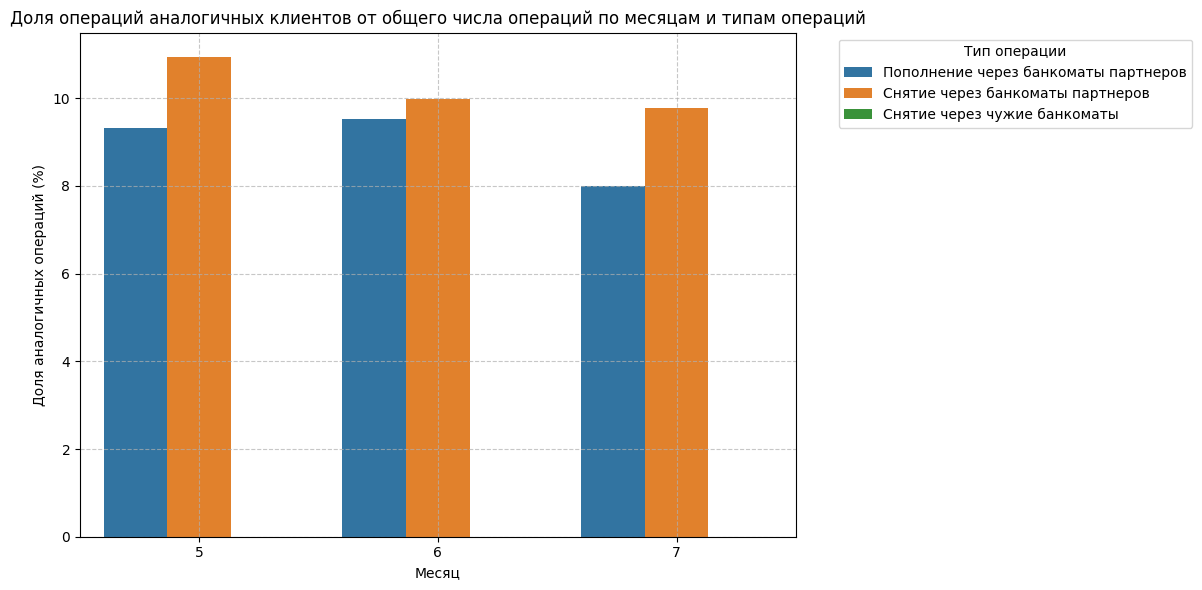

In [ ]:
# вывожу на график
#Доля операций аналогичных клиентов от общего числа операций по месяцам и типам операций
plt.figure(figsize=(12, 6))
sns.barplot(
    data=operation_ratios,
    x='MONTH',
    y='similar_operations_percentage',
    hue='OPERATION_TYPE',
    palette='tab10'
)

plt.title('Доля операций аналогичных клиентов от общего числа операций по месяцам и типам операций')
plt.xlabel('Месяц')
plt.ylabel('Доля аналогичных операций (%)')
plt.legend(title='Тип операции', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4.Всесторонний анализ датасета

проведите всесторонний анализ датасета, представив статистику в разных срезах с графиками (библиотеки python) и выводами.

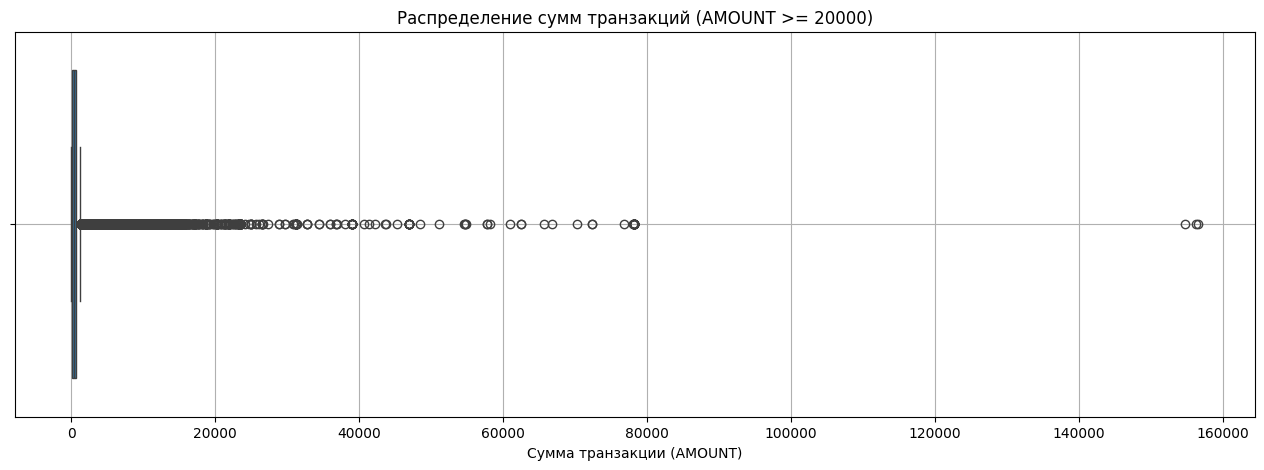

In [ ]:
#  распределение ключевых признаков с помощью boxplot
plt.figure(figsize=(16, 5))
sns.boxplot(x=data['AMOUNT'])
plt.title('Распределение сумм транзакций (AMOUNT >= 20000)')
plt.xlabel('Сумма транзакции (AMOUNT)')
plt.grid(True)

plt.show()


Распределение на графике боксплот нечитаемо из за такого перекоса
Посмотрим это распределение по диапазонам, так как у нас сильно скошенный датасет и 75% транзакций имеют сумму до 600 р.

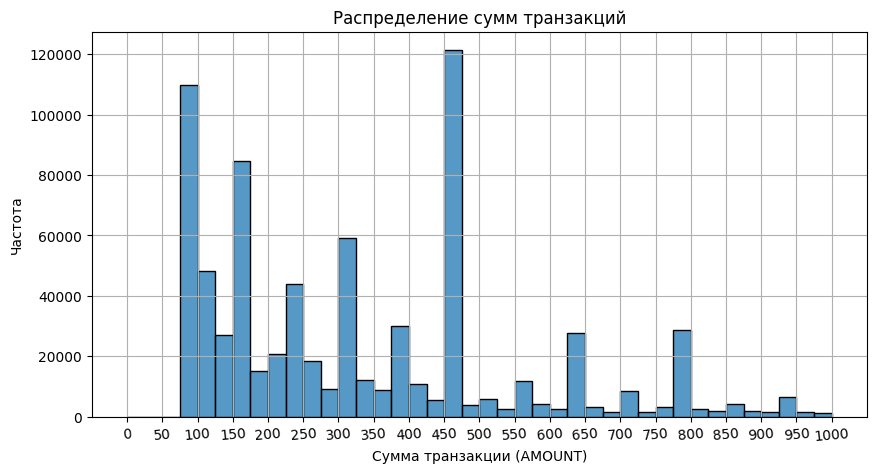

In [ ]:
#  распределение ключевых признаков
plt.figure(figsize=(10, 5))
sns.histplot(data.loc[data['AMOUNT'] <= 1000, 'AMOUNT'], bins=40)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакции (AMOUNT)')
plt.ylabel('Частота')
plt.grid(True)

# добавляю шаг меток на оси X
max_amount = data['AMOUNT'].loc[data['AMOUNT'] <= 1000].max()
plt.xticks(np.arange(0, max_amount + 50, 50), rotation = 5)  # Шаг 50

plt.show()


Первое что бросается в глаза это непрерывность признака, который должен быть ограничен номиналом банкнот, но это может быть обусловлено искусственностью датасета, огромное количество незначительных сумм и огромные хвосты, причем все что больше 1000 рублей в данном датасете это уже идет за пределом 3Q.

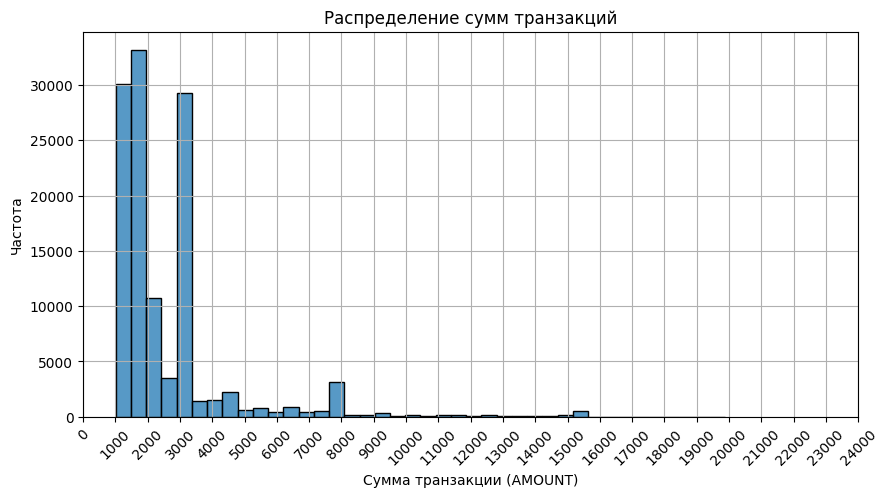

In [ ]:
#  распределение ключевых признаков
plt.figure(figsize=(10, 5))
sns.histplot(data.loc[(1000 < data['AMOUNT']) & (data['AMOUNT'] < 20000), 'AMOUNT'], bins = 40)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакции (AMOUNT)')
plt.ylabel('Частота')
plt.grid(True)
# добавляю шаг меток на оси X
max_amount = 25000
plt.xticks(np.arange(0, max_amount, 1000), rotation = 45)  # Шаг 50
plt.show()

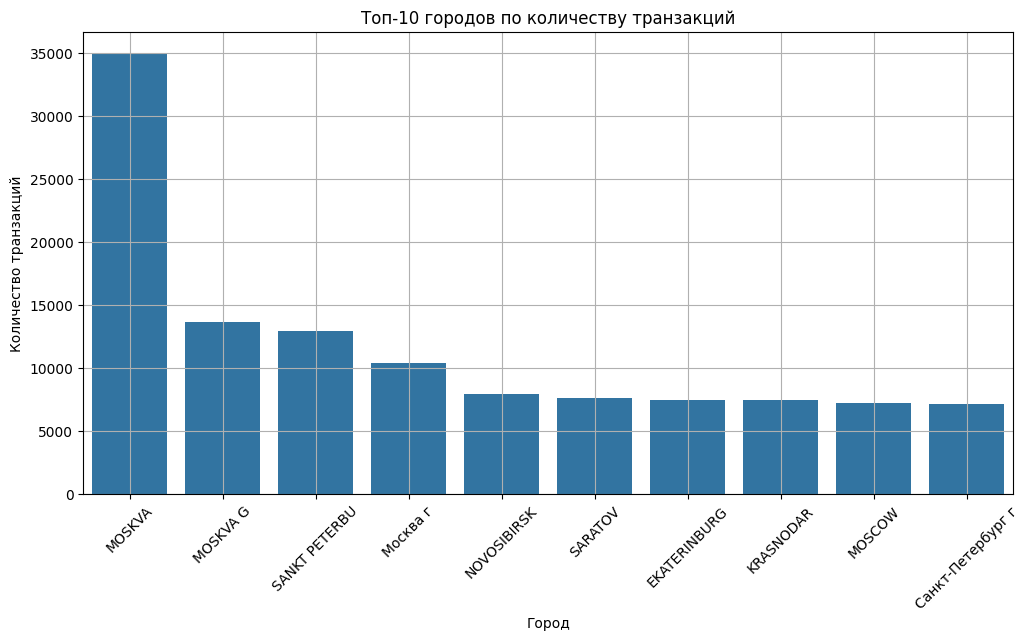

In [ ]:
#  количества транзакций по городам
plt.figure(figsize=(12, 6))
top_cities = data['CITY'].value_counts().nlargest(10)
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Топ-10 городов по количеству транзакций')
plt.xlabel('Город')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Неявные дубликаты мешают адекватно оценивать, заменю только основные

In [ ]:
# словарь с исправленными названиями городов
city_replacements = {
    'MOSCVA': 'Москва',
    'KAZAN': 'Казань',
    'SANKT PETERBU' : 'Санкт-Петербург',
    'Москва г' : 'Москва',
    'Moscow' : 'Москва',
    'Санкт-Петербург г' : 'Санкт-Петербург',
    'MOSCVA': 'Москва',
    'MOSKVA': 'Москва',
    'MOSKVA G': 'Москва',
    'MOSCOW': 'Москва',
    'SANKT PETERBURG' : 'Санкт-Петербург',}

# меняю значения в столбце 'CITY' по словарю
data['CITY'] = data['CITY'].replace(city_replacements)

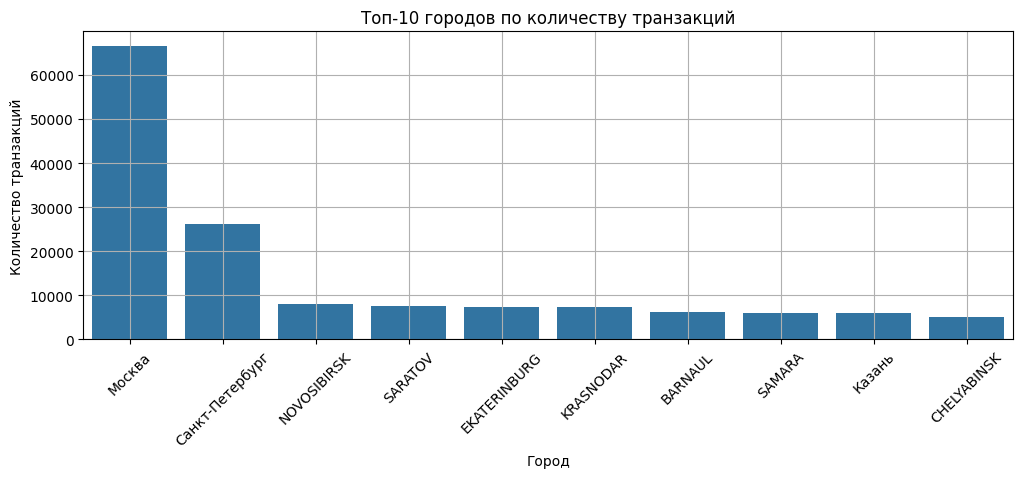

In [ ]:
#  количества транзакций по городам
plt.figure(figsize=(12, 4))
top_cities = data['CITY'].value_counts().nlargest(10)
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Топ-10 городов по количеству транзакций')
plt.xlabel('Город')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Распределение числа транзакций по городам выглядит очень логичным и согласуется с размером и значением городов в России

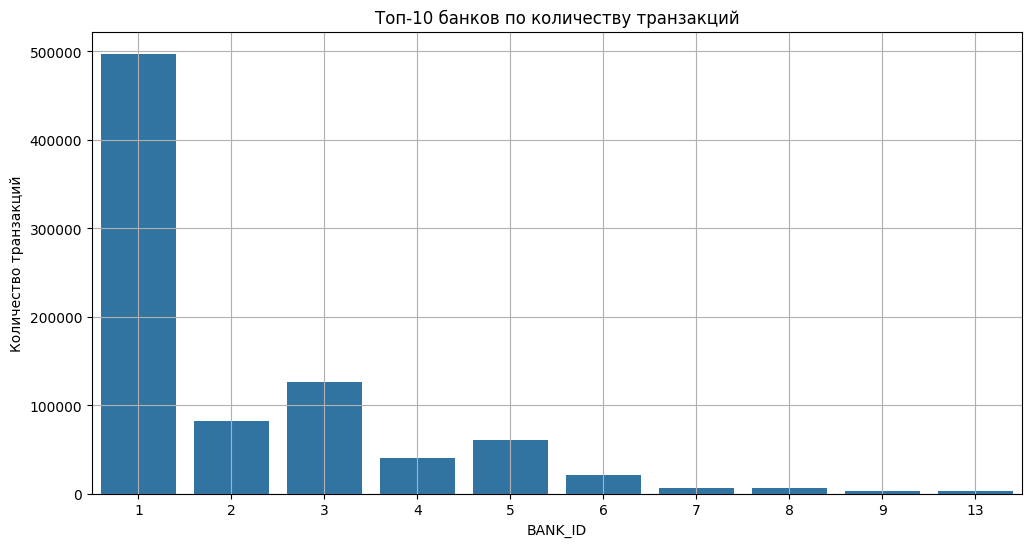

In [ ]:
# количества транзакций по банкам
plt.figure(figsize=(12, 6))
top_banks = data['BANK_ID'].value_counts().nlargest(10)
sns.barplot(x=top_banks.index, y=top_banks.values)
plt.title('Топ-10 банков по количеству транзакций')
plt.xlabel('BANK_ID')
plt.ylabel('Количество транзакций')
plt.grid(True)
plt.show()



Этот вид распределений мы подробно анализировали в разделе 1 этой работы, поэтому не буду останавливаться повторно.

In [ ]:
fraud_counts = data['FRAUD_FLAG'].value_counts(normalize=True) * 100
print("\nПроцент фродовых и нефродовых транзакций:\n", fraud_counts)


Процент фродовых и нефродовых транзакций:
 FRAUD_FLAG
0    99.940493
1     0.059507
Name: proportion, dtype: float64


В данном датасте фродовые признаки имеются  только в транзакциях одного месяца (7). Это будет иметь значение для дальнейшей работы с машинным обучением. Такой сильный дисбаланс классов сильно влияет на машинное обучение и это нужно обрабатывать.

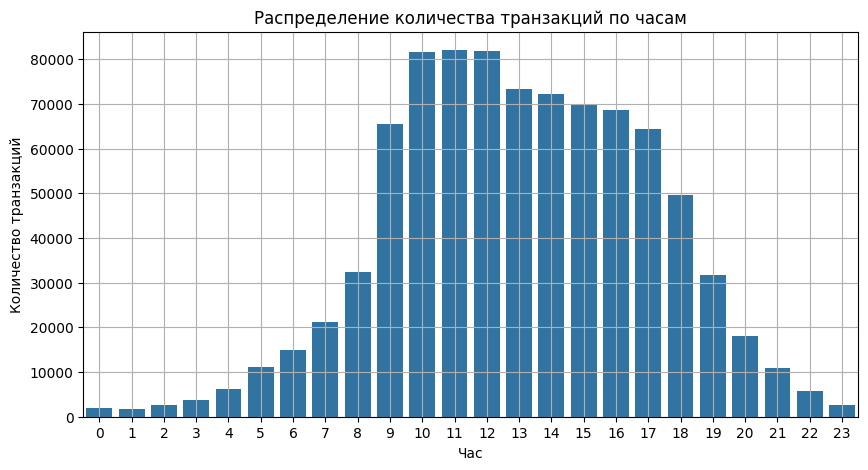

In [ ]:
# количество транзакций по часам
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='HOUR')
plt.title('Распределение количества транзакций по часам')
plt.xlabel('Час')
plt.ylabel('Количество транзакций')
plt.grid(True)
plt.show()

По часам распределение не вызывает вопросов, распределение похоже на нормальное, с небольшим смещением вправо.

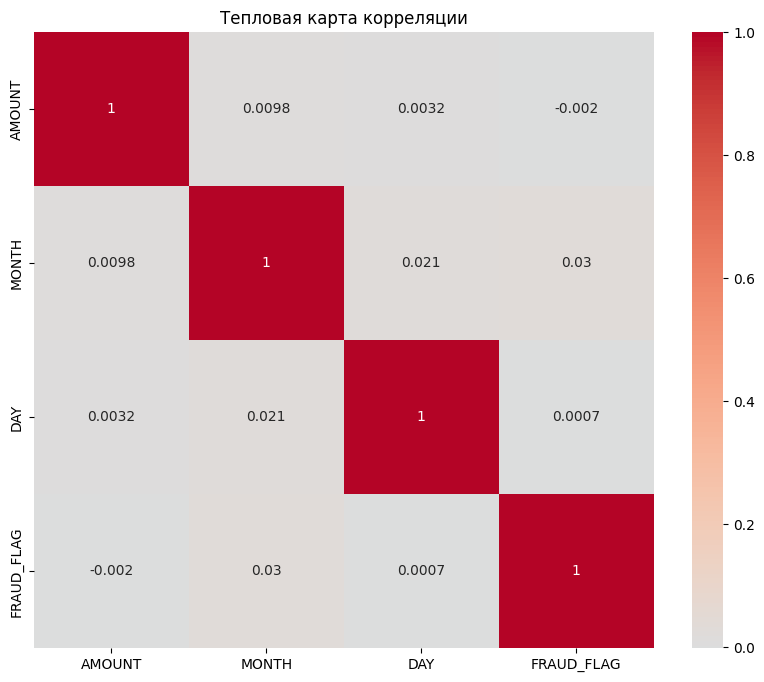

In [ ]:
# Корреляция между числовыми признаками
correlation_matrix = data[['AMOUNT', 'MONTH', 'DAY', 'FRAUD_FLAG']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', center=0)
plt.title('Тепловая карта корреляции')
plt.show()

Видим что линейной зависимости между исходными признаками нет. Но это говорит лишь об отсутствии линейной зависимости а не о любой


Средние суммы транзакций по топ-10 банкам:



,AMOUNT
BANK_ID,
12,1205.483328
25,1010.450704
14,924.939271
17,883.569385
9,874.946682
13,839.540533
44,772.888889
40,770.960187
26,747.456059


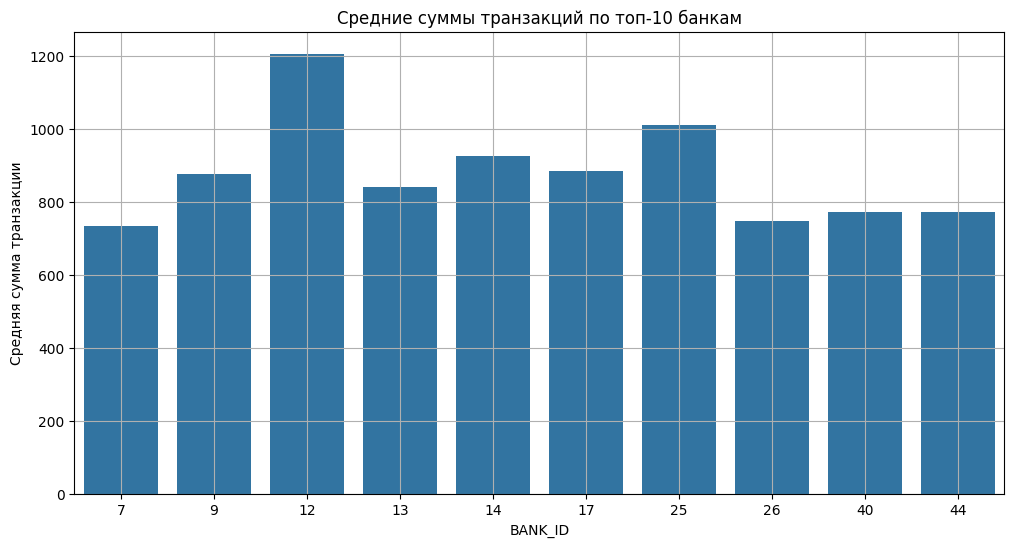

In [ ]:
# средние суммы транзакций в разрезе банков
bank_mean_amounts = data.groupby('BANK_ID')['AMOUNT'].mean().nlargest(10)
print("\nСредние суммы транзакций по топ-10 банкам:\n")
display(bank_mean_amounts)

plt.figure(figsize=(12, 6))
sns.barplot(x=bank_mean_amounts.index, y=bank_mean_amounts.values)
plt.title('Средние суммы транзакций по топ-10 банкам')
plt.xlabel('BANK_ID')
plt.ylabel('Средняя сумма транзакции')
plt.grid(True)
plt.show()

Этот график интересен тем, что по средним значениям в топ 10 попали другие банки нежели топ 5 и боттом 5.
Это может говорить о том что они проводят менее частые, но более крупные транзакции.

# ML

Подход для машинного обучения будет зависетьот того как распределен целевой признак. У нас задача классификации, но данных с меткой 1 критично мало, поэтому сначала исследуем этот аспект

In [ ]:
print(f"Процент данных с меткой 1: {data['FRAUD_FLAG'].mean()}")

Процент данных с меткой 1: 0.0005950725702443116


Это очень мало, необходимо уменьшить размер выборки чтобы она была сопоставима.

In [ ]:
# категориальные признаки
categorical_features = ['CITY', 'OPERATION_TYPE', 'BANK_ID']

<Figure size 1000x600 with 0 Axes>

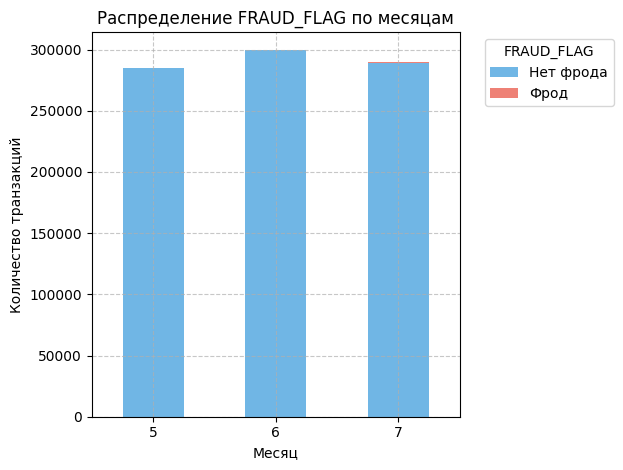

In [ ]:
#  распределения FRAUD_FLAG по месяцам чтобы найти на каких месяцах обучить модель
fraud_distribution = data.groupby(['MONTH', 'FRAUD_FLAG'])['TRANSACTION_ID'].count().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
fraud_distribution.plot(kind='bar', stacked=True, color=['#3498db', '#e74c3c'], alpha=0.7)
plt.title('Распределение FRAUD_FLAG по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=0)
plt.legend(title='FRAUD_FLAG', labels=['Нет фрода', 'Фрод'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Видим что фрод у нас только в одном месяце, значит для задач классификации  мы можем брать только 7 месяц. Но в 5, 6 месяцах совсем отсутствует метка 1. Но в предыдущем шаге я вручную отбирала подозрительные транзакции, поэтому я проанализирую насколько это совпадет с предсказаниями модеи.
А также я сделаю проверку аномалий с помощью алгоритма dbscan

In [ ]:
# данные для 5 и 6 месяцев для обучения и 7-го месяца для предсказаний
train_data = data[data['MONTH'] == 7]
predict_data = data[data['MONTH'].isin([5, 6])]

In [ ]:
fraud_data = train_data[train_data['FRAUD_FLAG'] == 1]
non_fraud_data = train_data[train_data['FRAUD_FLAG'] == 0]

# downsampling для класса 0 до уровня класса 1
non_fraud_data_downsampled = resample(
    non_fraud_data,
    replace=False,
    n_samples = 3*len(fraud_data),
    random_state=42
)

# собираю данные обратно в один датасет
train_data = pd.concat([fraud_data, non_fraud_data_downsampled])

# размер  данных
print(f"Количество записей после downsampling: {train_data.shape[0]}")
print(train_data['FRAUD_FLAG'].value_counts())

Количество записей после downsampling: 2080
FRAUD_FLAG
0    1560
1     520
Name: count, dtype: int64


In [ ]:
train_data['FRAUD_FLAG'].unique()

array([1, 0])

In [ ]:
# делю на обучающие и целевые признаки обучения модели
X_train = train_data.drop(['FRAUD_FLAG', 'TIME', 'TRANSACTION_ID', 'CLIENT_ID', 'MONTH', 'YEAR'], axis=1)
y_train = train_data['FRAUD_FLAG']

# предсказываю на 5-6 месяц
X_predict = predict_data.drop(['FRAUD_FLAG', 'TIME', 'TRANSACTION_ID', 'CLIENT_ID', 'MONTH', 'YEAR'], axis=1)

# категориальные признаки в строки для использования в CatBoost
for cat_feature in categorical_features:
    X_predict[cat_feature] = X_predict[cat_feature].astype(str)
    X_train[cat_feature] = X_train[cat_feature].astype(str)

# деление обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify = y_train
)

In [ ]:
# обучаю модель CatBoostClassifier на базовых параметрах
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_features,
    verbose=100,
    random_seed=42
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

#  оценка модели
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6201243	test: 0.6200357	best: 0.6200357 (0)	total: 54.2ms	remaining: 27s
100:	learn: 0.1044665	test: 0.1010266	best: 0.1010266 (100)	total: 518ms	remaining: 2.05s
200:	learn: 0.0631953	test: 0.0801998	best: 0.0801998 (200)	total: 956ms	remaining: 1.42s
300:	learn: 0.0413376	test: 0.0722423	best: 0.0722423 (300)	total: 1.42s	remaining: 937ms
400:	learn: 0.0292990	test: 0.0667856	best: 0.0667181 (399)	total: 1.86s	remaining: 458ms
499:	learn: 0.0218782	test: 0.0657782	best: 0.0657578 (489)	total: 2.32s	remaining: 0us

bestTest = 0.06575779483
bestIteration = 489

Shrink model to first 490 iterations.


In [ ]:
# метрики модели
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Precision: 0.9196
Recall: 0.9904
F1 Score: 0.9537
ROC AUC Score: 0.9963

Confusion Matrix:
[[303   9]
 [  1 103]]


Получила отличный результат, модель отлично справляется и с 1 и с 0 классом.

In [ ]:
# отчет по классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       312
           1       0.92      0.99      0.95       104

    accuracy                           0.98       416
   macro avg       0.96      0.98      0.97       416
weighted avg       0.98      0.98      0.98       416



## Анализ важности признаков

In [ ]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_


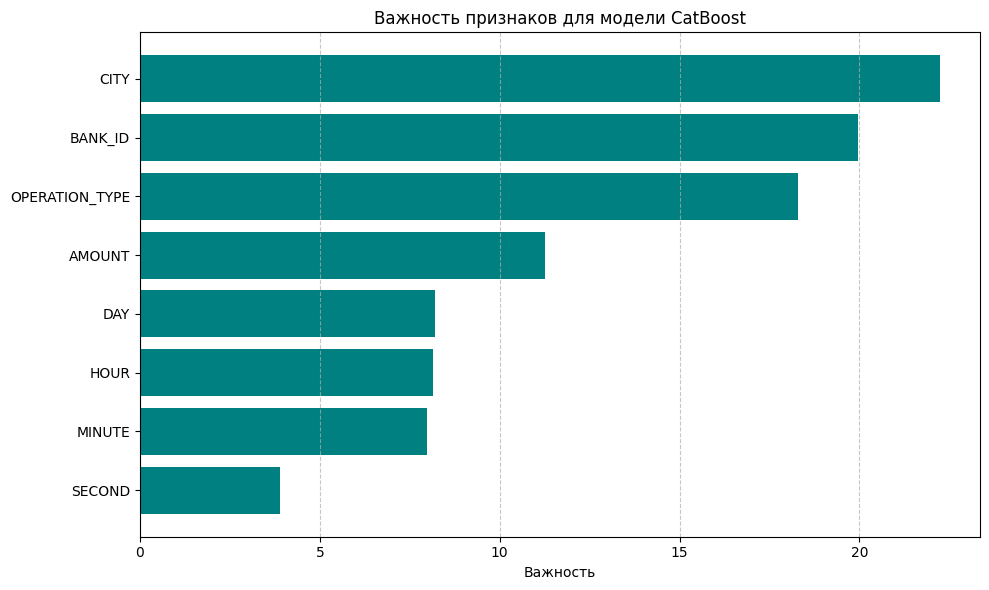

In [ ]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title('Важность признаков для модели CatBoost')
plt.xlabel('Важность')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Видим что самый важный признак это название города и банк. Возможно даже лучше что я не обработала неявные дубликаты, так как возможно эти неправильные названия дают уточненное местоположение банкомата

## **Предсказываю на тестовые 5, 6 месяцы**

In [ ]:
# метка фрода для 5-6 месяца
y_predict = model.predict(X_predict)
y_predict_proba = model.predict_proba(X_predict)[:, 1]

In [ ]:
predict_data['predicted_fraud_flag'] = y_predict
predict_data['fraud_probability'] = y_predict_proba

# реальные метки и предсказанные для расчета метрик
y_true = predict_data['FRAUD_FLAG']
y_pred = predict_data['predicted_fraud_flag']
y_pred_proba = predict_data['fraud_probability']

<ipython-input-80-2e06f024d15b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['predicted_fraud_flag'] = y_predict
<ipython-input-80-2e06f024d15b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['fraud_probability'] = y_predict_proba


In [ ]:
predict_data['y_pred'] = y_pred

<ipython-input-81-30e325429aa7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['y_pred'] = y_pred


In [ ]:
predict_data.columns

Index(['TIME', 'TRANSACTION_ID', 'AMOUNT', 'CLIENT_ID', 'BANK_ID', 'CITY',
       'OPERATION_TYPE', 'FRAUD_FLAG', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'SECOND', 'predicted_fraud_flag', 'fraud_probability',
       'y_pred'],
      dtype='object')

In [ ]:
similar_clients.columns

Index(['CLIENT_ID', 'OPERATION_TYPE', 'CITY', 'BANK_ID', 'MONTH', 'AMOUNT'], dtype='object')

In [ ]:
similar_clients[similar_clients['MONTH'].isin([5,6])].shape[0]

13892

In [ ]:
similar_clients.columns

Index(['CLIENT_ID', 'OPERATION_TYPE', 'CITY', 'BANK_ID', 'MONTH', 'AMOUNT'], dtype='object')

In [ ]:
predict_data.columns

Index(['TIME', 'TRANSACTION_ID', 'AMOUNT', 'CLIENT_ID', 'BANK_ID', 'CITY',
       'OPERATION_TYPE', 'FRAUD_FLAG', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'SECOND', 'predicted_fraud_flag', 'fraud_probability',
       'y_pred'],
      dtype='object')

In [ ]:
# вывожу датафрейм обеденный по общим признакам
# с типом объединения inner
common_fraud_cases = pd.merge(
    similar_clients,
    predict_data[predict_data['y_pred'] == 1],
    on=['CLIENT_ID', 'OPERATION_TYPE', 'CITY', 'BANK_ID', 'MONTH', 'AMOUNT'],
    how='inner'
)

#  количество совпадающих транзакций
print(f"Количество совпадающих транзакций: {common_fraud_cases.shape[0]}")

Количество совпадающих транзакций: 17168


In [ ]:
match_count = common_fraud_cases.shape[0]
total_count = similar_clients.shape[0]

percentage_match = (match_count / total_count) * 100

print(f"Процент совпадений меток фрода для клиентов, отобранных вручную и с помощью модели: {percentage_match:.2f}%")

Процент совпадений меток фрода для клиентов, отобранных вручную и с помощью модели: 84.28%


Мы получили вывод, что мы нашли 84% подозрительных транзакций. Но этот результат нужно дорабатывать, так как мы предсказывали на 5, 6 месяцы, а в подозрительных транзакциях сидят все 3 месяца.
Мне необходимо было бы найти id самих транзакций, а не клиентов.

Но такое совпадение вероятно получилось что данные размножались и сходным данным присваивали другие id транзакций. Тем не менее, мы нашли большое число подозрительных транзакций и оно совпало с тем что мы нашли вручную.